### Utility functions

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pixiedust

def conv_params(in_size, out_size):
    filters = [3,2,5,4]
    strides = [1,2,3] # max_stride = 3
    pads = [0,1,2,3] # max pad
    
    if out_size == 1:
        return 1, 0, in_size
    
    for filter_size in filters:
        for pad in pads:
            for stride in strides:
                if ((out_size - 1) * stride == (in_size - filter_size) + 2 * pad):
                    return stride, pad, filter_size
    return None, None, None

class StdConv(nn.Module):
    def __init__(self, nin, nout, filter_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, filter_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): 
        return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (num_classes)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 3*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSDHead(nn.Module):
    def __init__(self, grids, anchors_per_cell, num_classes, drop=0.3, bias=-4.):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        self.sconvs = nn.ModuleList([])
        self.oconvs = nn.ModuleList([])
        
        self.anc_grids = grids
        
        self._k = anchors_per_cell

        
        self.sconvs.append(StdConv(512, 256, stride=1, drop=drop))
        
        
        for i in range(len(grids)):
            
            if i == 0:
                stride, pad, filter_size = conv_params(7, grids[i]) # get '7' by base model
            else:
                stride, pad, filter_size = conv_params(grids[i-1], grids[i])
            
            if stride is None:
                print(grids[i-1], ' --> ', grids[i])
                raise Exception('cannot create model for specified grids')
                
            self.sconvs.append(StdConv(256, 256, filter_size, stride=stride, padding=pad, drop=drop))
            self.oconvs.append(OutConv(self._k, 256, num_classes=num_classes, bias=bias))
                
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconvs[0](x)
        out_classes = []
        out_bboxes = []
        for sconv, oconv in zip(self.sconvs[1:], self.oconvs):
            x = sconv(x)
            out_class, out_bbox = oconv(x)
            out_classes.append(out_class)
            out_bboxes.append(out_bbox)
            
        return [torch.cat(out_classes, dim=1),
                torch.cat(out_bboxes, dim=1)]

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,1:].contiguous()).cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/(self.num_classes-1)
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        w = w * (1-pt).pow(gamma)
        return w.detach()

Pixiedust database opened successfully


### SingleShotDetector

In [2]:
import torch
from fastai.vision.learner import create_cnn
from torchvision.models import resnet34
import numpy as np
import json
import os
from pathlib import Path

class _EmptyData():
    def __init__(self, path, c, loss_func: None):
        self.path = path
        self.device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
        self.c = c
        self.loss_func = loss_func

class SingleShotDetector(object):
    
    def __init__(self, data, grids=[4, 2, 1], zooms=[0.7, 1., 1.3], ratios=[[1., 1.], [1., 0.5], [0.5, 1.]], 
                 backbone=None, drop=0.3, bias=-4., focal_loss=False, pretrained_path=None):
        
        super().__init__()

        self._device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')


        if backbone is None:
            backbone = resnet34
            
        self._create_anchors(grids, zooms, ratios)
        
        ssd_head = SSDHead(grids, self._anchors_per_cell, data.c, drop=drop, bias=bias)

        self._data = data
        self.learn = cnn_learner(data=data, base_arch=backbone, custom_head=ssd_head)
        self.learn.model = self.learn.model.to(self._device)

        if pretrained_path is not None:
            self.load(pretrained_path)
        
        if focal_loss:
            self._loss_f = FocalLoss(data.c)
        else:
            self._loss_f = BCE_Loss(data.c)
            
        self.learn.loss_func = self._ssd_loss

    @classmethod
    def from_emd(cls, data, emd_path):
        emd = json.load(open(emd_path))
        class_mapping = {i['Value'] : i['Name'] for i in emd['Classes']}
        if data is None:
            empty_data = _EmptyData(path='str', loss_func=None, c=len(class_mapping) + 1)
            return cls(empty_data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])
        else:
            return cls(data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])

    
    def lr_find(self):
        from IPython.display import clear_output
        self.learn.lr_find()
        clear_output()
        self.learn.recorder.plot()
        
    def fit(self, epochs=10, lr=slice(1e-4,3e-3)):
        self.learn.fit(epochs, lr)
        
    def fit_one_cycle(self, epochs=10, lr=slice(1e-4,3e-3)):
        self.learn.fit_one_cycle(epochs, lr)

    def unfreeze(self):
        self.learn.unfreeze()
        
    def _create_anchors(self, anc_grids, anc_zooms, anc_ratios):
        
        self.grids = anc_grids
        self.zooms = anc_zooms
        self.ratios =  anc_ratios

        anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
        
        self._anchors_per_cell = len(anchor_scales)
        
        anc_offsets = [1/(o*2) for o in anc_grids]

        anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), self._anchors_per_cell, axis=0)

        anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])
        
        self._grid_sizes = torch.Tensor(np.concatenate([np.array([ 1/ag  for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])).unsqueeze(1).to(self._device)
        
        self._anchors = torch.Tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float().to(self._device)
        
        self._anchor_cnr = self._hw2corners(self._anchors[:,:2], self._anchors[:,2:])
        
    def _hw2corners(self, ctr, hw): 
        return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

    def _get_y(self, bbox, clas):
        bbox = bbox.view(-1,4) #/sz
        bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
        return bbox[bb_keep],clas[bb_keep]

    def _actn_to_bb(self, actn, anchors, grid_sizes):
        actn_bbs = torch.tanh(actn)
        actn_centers = (actn_bbs[...,:2]/2 * grid_sizes) + anchors[:,:2]
        actn_hw = (actn_bbs[...,2:]/2+1) * anchors[:,2:]
        return self._hw2corners(actn_centers, actn_hw)

    def _map_to_ground_truth(self, overlaps, print_it=False):
        prior_overlap, prior_idx = overlaps.max(1)
        if print_it: print(prior_overlap)
        gt_overlap, gt_idx = overlaps.max(0)
        gt_overlap[prior_idx] = 1.99
        for i,o in enumerate(prior_idx): gt_idx[o] = i
        return gt_overlap, gt_idx
        
        
    def _ssd_1_loss(self, b_c, b_bb, bbox, clas, print_it=False):
        bbox,clas = self._get_y(bbox,clas)
        bbox = self._normalize_bbox(bbox)

        a_ic = self._actn_to_bb(b_bb, self._anchors, self._grid_sizes)
        overlaps = self._jaccard(bbox.data, self._anchor_cnr.data)
        try:
            gt_overlap,gt_idx = self._map_to_ground_truth(overlaps,print_it)
        except Exception as e:
            return 0.,0.
        gt_clas = clas[gt_idx]
        pos = gt_overlap > 0.4
        pos_idx = torch.nonzero(pos)[:,0]
        gt_clas[1-pos] = 0 #data.c - 1 # CHANGE
        gt_bbox = bbox[gt_idx]
        loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
        clas_loss  = self._loss_f(b_c, gt_clas)
        return loc_loss, clas_loss
    
    def _ssd_loss(self, pred, targ1, targ2, print_it=False):
        lcs,lls = 0.,0.
        for b_c,b_bb,bbox,clas in zip(*pred, targ1, targ2):
            loc_loss,clas_loss = self._ssd_1_loss(b_c,b_bb,bbox.cuda(),clas.cuda(),print_it)
            lls += loc_loss
            lcs += clas_loss
        if print_it: print(f'loc: {lls}, clas: {lcs}') #CHANGE
        return lls+lcs
    
    def _intersect(self,box_a, box_b):
        max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
        min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
        inter = torch.clamp((max_xy - min_xy), min=0)
        return inter[:, :, 0] * inter[:, :, 1]

    def _box_sz(self, b): 
        return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

    def _jaccard(self, box_a, box_b):
        inter = self._intersect(box_a, box_b)
        union = self._box_sz(box_a).unsqueeze(1) + self._box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    
    def _normalize_bbox(self, bbox): 
        return (bbox+1.)/2.

    
    
    def save(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai save to both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            if not os.path.exists(self.learn.path):
                os.makedirs(self.learn.path)            
            saved_path = self.learn.save(name, return_path=True)
            # undoing changes to self.learn.path and self.learn.model
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent
            if not os.path.exists(self.learn.path / self.learn.model_dir):
                os.makedirs(self.learn.path / self.learn.model_dir)            
            saved_path = self.learn.save(name_or_path,  return_path=True)
            # undoing changes to self.learn.path
            self.learn.path = temp

    def load(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai from both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            self.learn.load(name)
            # undoing changes to self.learn.path and self.learn.model_dir
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent            
            self.learn.load(name_or_path)
            # undoing changes to self.learn.path
            self.learn.path = temp
        
    def show_results(self, rows=5, thresh=0.5, nms_overlap=0.1):
        self.learn.show_results(rows=rows, thresh=thresh, nms_overlap=nms_overlap, ssd=self)

### Pascal VOC Data

In [3]:
import fastai
import numpy as np
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.vision import *
%matplotlib inline

In [4]:
PATH = Path(r'data/cardBB')
JPEGS = 'img'
IMG_PATH = PATH/JPEGS

In [5]:
images, lbl_bbox = get_annotations(PATH/'cardBB.json')

img2bbox = dict(zip(images, lbl_bbox))
def get_y_func(x):
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes] 

In [6]:
from ssdoil import SSDObjectItemList

data = (SSDObjectItemList.from_folder(PATH/JPEGS)
        .split_by_rand_pct()       
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=16, collate_fn=bb_pad_collate))
        #.normalize(imagenet_stats)) 

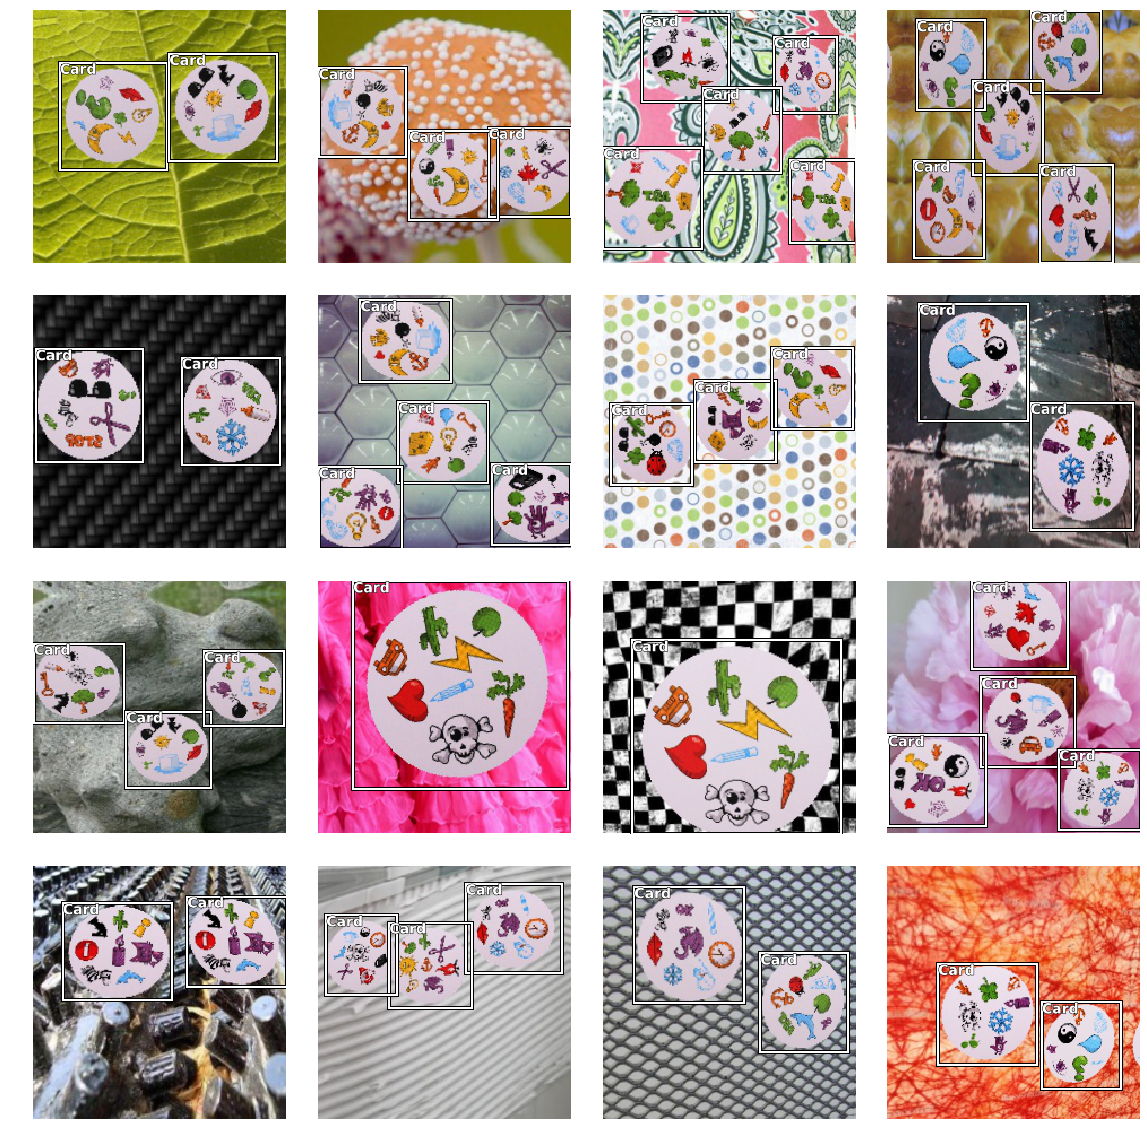

In [7]:
#%%time
data.show_batch()

In [7]:
ssd = SingleShotDetector(data, ratios=[[1.0, 1.0]])

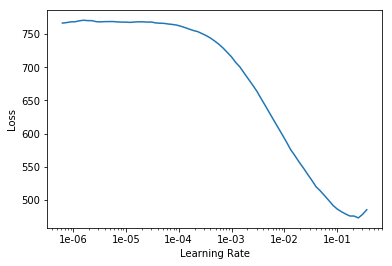

In [8]:
ssd.lr_find()

In [9]:
ssd.fit_one_cycle(10, lr=1e-2)

In [14]:
ssd.learn.save('ssd-tuesday3-20')

In [17]:
ssd.learn.load('ssd-tuesday3-20')

/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BCE_Loss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (2400 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/cardBB/img;

Valid: LabelList (600 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/cardBB/img;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0)

In [12]:
ssd.save('ssd-tuesday3-20')

In [19]:
ssd.load('ssd-tuesday3-20')

/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SSDHead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StdConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type OutConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BCE_Loss. It won't be checked for corre

In [14]:
ssd.unfreeze()

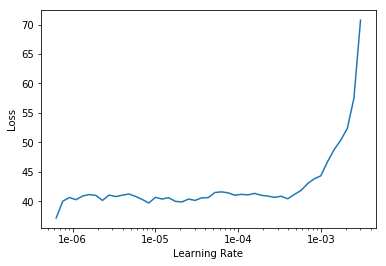

In [18]:
ssd.lr_find()

In [19]:
ssd.fit_one_cycle(10, lr=slice(1e-5,1e-3))

In [20]:
ssd.save('ssd-tuesday2-20')

In [21]:
ssd.learn.save('ssd-tuesday2-20')

In [8]:
ssd.learn.load('ssd-tuesday2-20')

/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SSDHead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StdConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type OutConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/callum/anaconda3/envs/dobble2/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BCE_Loss. It won't be checked for corre

Learner(data=ImageDataBunch;

Train: LabelList (2400 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/cardBB/img;

Valid: LabelList (600 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/cardBB/img;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0)

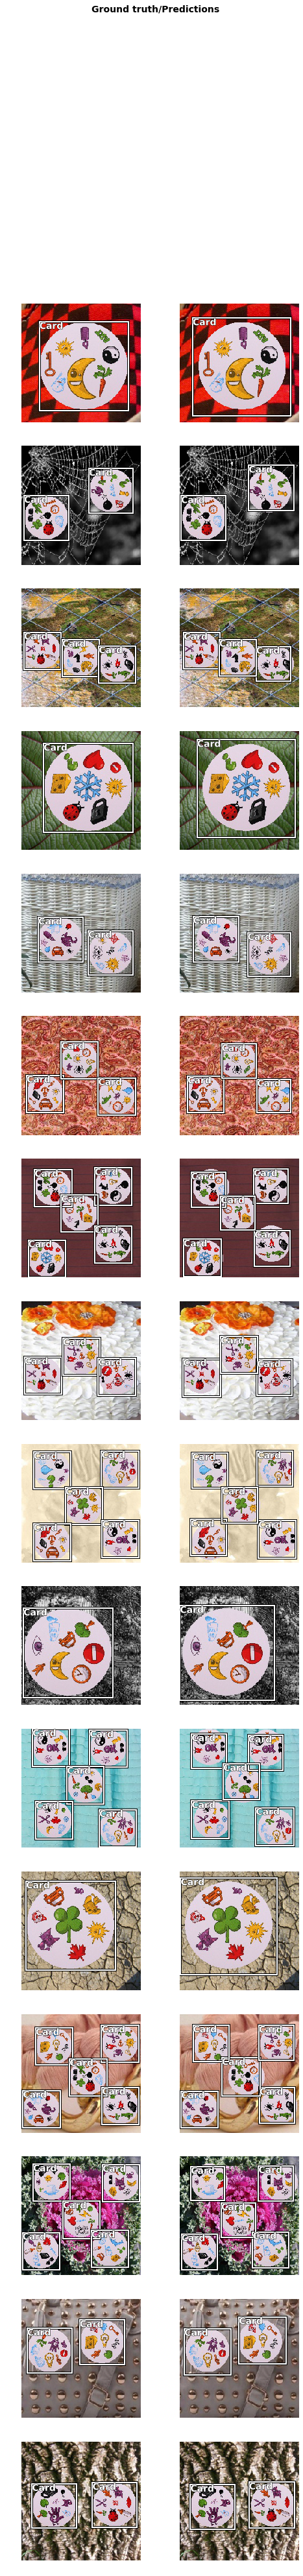

In [23]:
#%%pixie_debugger
ssd.show_results(rows=64, thresh=0.1)

In [9]:
def card_cutout(img, bboxes):
    size = img.size(1)
    n = len(bboxes)
    bboxes = (bboxes + 1)*size/2
    mean = int((bboxes[:,2] - bboxes[:,0]).mean())
    bboxes = bboxes.type(torch.int)
    #out = torch.cuda.IntTensor(n,mean,mean)
    out = (img[:, bboxes[0][0]:bboxes[0][0]+mean, bboxes[0][1]:bboxes[0][1]+mean]).unsqueeze(0)
    for i in range(1,n):
        #out[i] = img[:, bboxes[i][0]:bboxes[i][0]+mean, bboxes[i][1]:bboxes[i][1]+mean]
        out = torch.cat((out, (img[:, bboxes[i][0]:bboxes[i][0]+mean, bboxes[i][1]:bboxes[i][1]+mean]).unsqueeze(0)))
    return out

In [10]:
it = iter(ssd.learn.data.valid_dl)
for x in range(3):
    xb, yb = next(it)

In [11]:
#one_y = [yb[0][0].unsqueeze(0),yb[1][0].unsqueeze(0)]
one_y = [torch.FloatTensor(1,1,4),torch.FloatTensor(1,5)]

In [12]:
y=ssd.learn.pred_batch(batch = [xb[0].unsqueeze(0), one_y])

In [14]:
import ssdoil
bboxes = ssdoil.SSDObjectCategoryList.analyze_pred(pred = grab_idx(y, 0), thresh=0.2, ssd=ssd)[0]

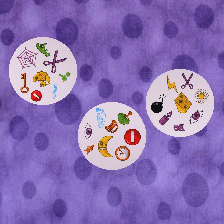

In [18]:
Image(xb[0])

In [19]:
cards = card_cutout(xb[0], bboxes)#yb[0][0][1:]

In [20]:
xb[0].size(1)

224

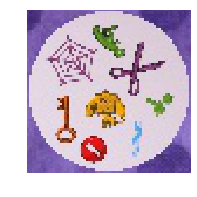

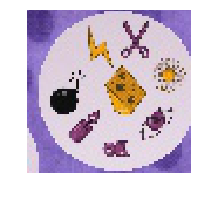

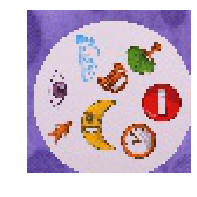

In [21]:
for i in range(len(cards)):
    Image(cards[i]).show()

In [33]:
#cap.release()

In [66]:
import cv2
cap = cv2.VideoCapture(-1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
offset = int((1280-720)/2)


for x in range(1):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = frame[:,offset:1280-offset,:]
    frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
    frame = np.transpose(frame, (2, 0, 1))
    frame = tensor(frame)
    frame = frame.float()
    frame = frame.unsqueeze(0)
    frame = frame.cuda()
    frame = frame/255

# When everything done, release the capture
cap.release()

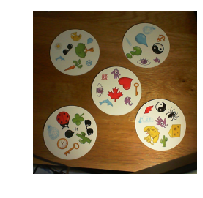

In [67]:
Image(frame[0],).show()

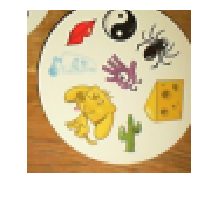

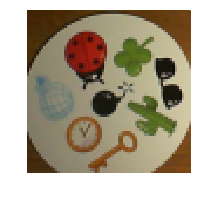

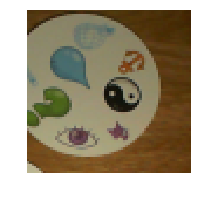

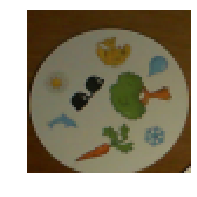

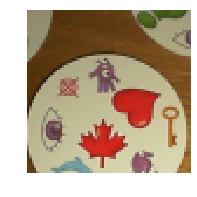

In [235]:
y=ssd.learn.pred_batch(DatasetType.Valid, batch = [frame, one_y])
i=0
bboxes = ssd.learn.data.train_ds.y.analyze_pred(grab_idx(y, i), thresh=0.2, ssd=ssd)[0]
cards = card_cutout(frame[0], bboxes)
for i in range(len(cards)):
    Image(cards[i]).show()

In [70]:
classGuesser = load_learner("models")

In [238]:
torch.topk(classGuesser.model(cards),8)[1]

tensor([[43, 36, 49, 12,  3,  7, 51, 14],
        [23,  2,  8, 48, 22, 24, 38,  3],
        [43, 30, 31, 47,  0, 22, 16, 42],
        [41, 39, 31,  7, 13, 33,  6, 10],
        [23, 16, 39, 13, 27, 14, 49, 20]], device='cuda:0')

In [241]:
idx = np.array(torch.topk(classGuesser.model(cards),8)[1])

In [244]:
idx[0]

array([43, 36, 49, 12,  3,  7, 51, 14])

In [250]:
matches = []
for i in range(5):
    for j in range(i+1,5):
        matches.append(np.intersect1d(idx[i], idx[j]))

In [252]:
for x in matches:
    print([classGuesser.data.classes[i] for i in x])

['Cactus']
['YinYang']
['Cheese']
['Dragon', 'dobble']
['Igloo']
[]
['Key']
['Question']
['Eye']
['Dolphin', 'Target']


In [202]:
[classGuesser.data.classes[i] for i in range(idx.size())]

TypeError: only integer tensors of a single element can be converted to an index

In [199]:
[classGuesser.data.classes[i] for i in [1,3,5]]

KeyError: (1, 3, 5)